<a href="https://colab.research.google.com/github/SergioPGJunior/Detectar_Arritmia/blob/master/rede_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install wfdb

In [2]:
import pandas as pd
import numpy as np
import wfdb
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [3]:
def load_ecg(file):
    # Leitura e armazenamento dos dados
    record = wfdb.rdrecord(file)

    # Leitura e armazenamento das anotações
    annotation = wfdb.rdann(file, "atr")

    #Extrai os sinais
    p_signal = record.p_signal

    #Verifica se a frequência é 360
    assert record.fs == 360, "Frequência de amostragem não é 360"

    #Extrai os símbolos e anotações
    atr_sym = annotation.symbol
    atr_sample = annotation.sample

    return p_signal, atr_sym, atr_sample

def build_XY(p_signal, df_ann, num_cols, abnormal, num_sec, fs):
  # this function builds the X,Y matrices for each beat
  # it also returns the original symbols for Y

  num_rows = len(df_ann)
  X = np.zeros((num_rows, num_cols))
  Y = np.zeros((num_rows, 1))
  sym = []

  # keep track of rows
  max_row = 0
  for atr_sample, atr_sym in zip(df_ann.atr_sample.values, df_ann.atr_sym.values):
      left = max([0, (atr_sample - num_sec * fs)])
      right = min([len(p_signal), (atr_sample + num_sec * fs)])
      x = p_signal[left: right]
      if len(x) == num_cols:
          X[max_row, :] = x
          Y[max_row, :] = int(atr_sym in abnormal)
          sym.append(atr_sym)
          max_row += 1
  X = X[:max_row, :]
  Y = Y[:max_row, :]
  return X, Y, sym

In [4]:
# Caminho onde os arquivos da base de dados estão armazenados
path = "/content/drive/My Drive/mit-bih-arrhythmia-database-1.0.0/"

# Cria um dataframe com os nomes dos arquivos
rec = pd.read_csv(path + "RECORDS", names=['n'], dtype=str)

# Lista de nonbeats e abnormal
nonbeat = ['[', '!', ']', 'x', '(', ')', 'p', 't', '`', 'u', '\\', '^', '|', '~', '+', 's', 'T', '*', 'D', '=', '"', '@', 'Q', '?']
abnormal = ['V', 'A']

num_sec = 1
fs = 360

#Inicilaiza os vetores
num_cols = 2 * num_sec * fs #numero de colunas que vai armazenar um amostra 
X_all = np.zeros((1, num_cols)) #Cria um vetor com numero de elementos igual a num_cols e preenche com zeros 
Y_all = np.zeros((1, 1)) #cria um vetor com com um elemento e preenche com zero
sym_all = []

#Lista para controlar o número de batimentos de cada paciente
max_rows = []

for pt in rec.n:
  file = path + pt
  p_signal, atr_sym, atr_sample = load_ecg(file)
  
  if 'A' and 'V' in atr_sym:
    #Seleciona o sinal MLII
    p_signal = p_signal[:, 0]
    
    # Cria um df para excluir o que mão é um batimento
    df_ann = pd.DataFrame({'atr_sym': atr_sym,
                          'atr_sample': atr_sample})
    df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]
   
    X, Y, sym = build_XY(p_signal, df_ann, num_cols, abnormal, num_sec, fs)
    sym_all = sym_all + sym
    max_rows.append(X.shape[0])
    X_all = np.append(X_all, X, axis=0)
    Y_all = np.append(Y_all, Y, axis=0)

#Exclui a primeira linha que é formada por zeros
X_all = X_all[1:, :]
Y_all = Y_all[1:, :]

#Verifica se os tamanhos das matrizes fazem sentido
assert np.sum(max_rows) == X_all.shape[0], 'number of X, max_rows rows messed up'
assert Y_all.shape[0] == X_all.shape[0], 'number of X, Y rows messed up'
assert Y_all.shape[0] == len(sym_all), 'number of Y, sym rows messed up'

d = {x:np.count_nonzero(Y_all == x) for x in [0,1]} #Calcula quantas amostras cada classe possui 0 -> Normal, 1 -> Arritmia

print('Classes: ',d)
print('Quantidade total de amostras: ', len(X_all)) #Quantidade total de amostras

Classes:  {0: 55820, 1: 7979}
Quantidade total de amostras:  63799


In [5]:
#Processamento dos dados

scaler = StandardScaler()
scaler.fit(X_all)
X_all = scaler.transform(X_all)

X_train, X_test, y_train, y_test = train_test_split(X_all, Y_all, test_size=0.3)

In [6]:
#Busca em grade dos parâmetros hidden_layer_sizes e learning_rate_init da função MLPClassifier

hls_range = [5, 10, 15]  #hidden layer sizes
lr_range = [0.001, 0.01, 0.1] #learning_rate_init

param_grid = dict(hidden_layer_sizes=hls_range, learning_rate_init=lr_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(MLPClassifier(activation='tanh',solver='sgd',
                                  validation_fraction=0.1,early_stopping=True, 
                                  max_iter=500), param_grid=param_grid, cv=cv)
grid.fit(X_train, np.ravel(y_train))


print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'hidden_layer_sizes': 15, 'learning_rate_init': 0.01} with a score of 0.98


In [7]:
#Etapa de teste da rede neural

yhat = grid.predict(X_test)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat)
print('Recall: %f' % recall)
# confusion matrix
matrix = confusion_matrix(y_test, yhat)
print(matrix)

Accuracy: 0.983699
Precision: 0.976286
Recall: 0.893896
[[16646    53]
 [  259  2182]]


In [8]:
#Rede neural no Keras com os parâmetros encontrados na busca em grade

# create model
model = Sequential()
model.add(Dense(15, input_dim=X_train.shape[1], activation='tanh'))
#model.add(Dropout(rate=0.25))
model.add(Dense(1, activation='sigmoid'))

# Compile model
opt = SGD(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

#Dado que o número de amostras de batimentos normais é 7 vezes maior do que anormais, foi utilizado o balancemaneto das classes
class_weight = {0: 1.,
                1: 7.}

# Fit the model
history = model.fit(X_train, y_train, validation_split=0.1, epochs=500, batch_size=200, class_weight=class_weight, verbose=0, callbacks=[es, mc])


Epoch 00080: early stopping


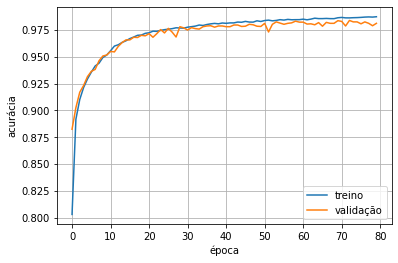

In [9]:
# Acurácias de validação e treino por épocas
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('acurácia')
plt.xlabel('época')
plt.legend(['treino', 'validação'], loc='lower right')
plt.grid()
plt.show()

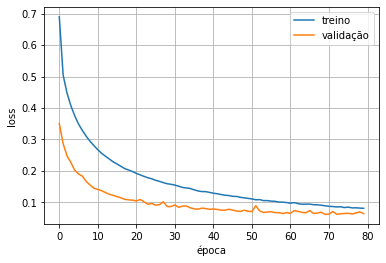

In [10]:
# Erros de validação e treino por épocas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('época')
plt.legend(['treino', 'validação'], loc='upper right')
plt.grid()
plt.show()